In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('archive/stock_details_5_years.csv', index_col='Date', parse_dates=True)
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
Date,,,,,,,,
2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


<AxesSubplot:title={'center':'Star Bucks Stock Volume'}, xlabel='Date'>

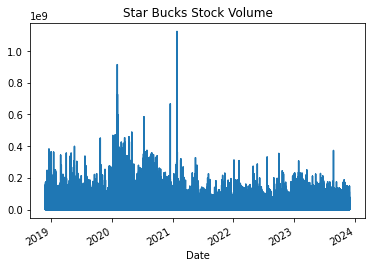

In [3]:

# plt.style.use('ggplot')
df['Volume'].plot(label='Close', title='Star Bucks Stock Volume')

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6] 
# print(X)
print(y)

                           Dividends
Date                                
2018-11-29 00:00:00-05:00       0.00
2018-11-29 00:00:00-05:00       0.00
2018-11-29 00:00:00-05:00       0.00
2018-11-29 00:00:00-05:00       0.00
2018-11-29 00:00:00-05:00       0.04
...                              ...
2023-11-29 00:00:00-05:00       0.00
2023-11-29 00:00:00-05:00       0.00
2023-11-29 00:00:00-05:00       0.00
2023-11-29 00:00:00-05:00       0.00
2023-11-29 00:00:00-05:00       0.00

[602962 rows x 1 columns]


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [6]:
#first 200 for training

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_mm[:200, :]
y_test = y_mm[200:, :] 

In [7]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 7) (200, 1)
Testing Shape (602762, 7) (602762, 1)


In [8]:
print(X_train[0])
print(y_test[39])

[-3.49471413e-01 -3.51215407e-01 -3.51741315e-01 -3.52158022e-01
  1.16665444e+01 -6.06263613e-02 -6.80264188e-03]
[0.]


In [9]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [10]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [17]:
print(X_train_tensors.shape)
print(X_train_tensors[199])
print(X_test_tensors[199])

print("===========")
print(y_train_tensors.shape)
print(y_train_tensors[199])

torch.Size([200, 7])
tensor([-0.0641, -0.0652, -0.0599, -0.0614, -0.3709, -0.0606, -0.0068])
tensor([-0.2491, -0.2512, -0.2492, -0.2524, -0.3157, -0.0606, -0.0068])
torch.Size([200, 1])
tensor([0.])


In [19]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 


In [26]:
print(X_train_tensors_final.shape)
print(X_train_tensors[0].shape)
print(X_train_tensors.shape[1])

torch.Size([200, 1, 7])
torch.Size([7])
7


In [27]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out